In [1]:
# !pip install gensim==3.8.3

## Khai báo các thư viện sử dụng

In [50]:
import nltk
import tensorflow as tf
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from gensim.models.doc2vec import TaggedDocument
import re
import matplotlib.pyplot as plt
import pickle
from sklearn import utils
# nltk.download()

Đường dẫn đến folder chứa project

In [51]:
origin_path = 'F:/Vlancer_Project/241.Luan_van_Chatbot_using_LSTM'

In [52]:
# Khai báo từ điển để chuyển tiếng việt CÓ dấu về tiếng việt KHÔNG dấu 
patterns = {
    '[àáảãạăắằẵặẳâầấậẫẩ]': 'a',
    '[đ]': 'd',
    '[èéẻẽẹêềếểễệ]': 'e',
    '[ìíỉĩị]': 'i',
    '[òóỏõọôồốổỗộơờớởỡợ]': 'o',
    '[ùúủũụưừứửữự]': 'u',
    '[ỳýỷỹỵ]': 'y'
}
# Khai báo các ký tự đặc biệt để loại bỏ
special_character = r'[!“”"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]'

# Khai báo danh sách các từ cần loại bỏ
stop_words = ['bạn', 'ban', 'anh', 'chị', 'chi', 'em', 'shop', 'bot', 'ad', 'là', 'có', 'và', 'hoặc', 'nếu', 'vậy', 'thế', 'còn']

# Hàm làm sạch các ký tự, chuyển thành tiếng việt không dấu và chuyển chữ thành chữ thường
def convert_to_no_accents(text):
    output = text
    for regex, replace in patterns.items():
        output = re.sub(regex, replace, output)
        output = re.sub(regex.upper(), replace.upper(), output)
        output = re.sub(special_character, '', output)
        output = output.lower()
    return output

Lấy dữ liệu đọc từ file JSON

In [53]:
trains = {}
# response = {}
with open(f'{origin_path}/data/chatbot_dataset_CMU.json', 'r', encoding='utf-8') as json_data:
    intents = json.load(json_data)
    for one_intent in intents['intents']:
        sentences = one_intent['patterns']
        trains[one_intent['tag']] = sentences
        # response[one_intent['tag']] = one_intent['responses']

Làm sạch dữ liệu và gán nhãn tương ứng

In [54]:
classes = {}
X_dev = []
y_dev = []
for i, (key, value) in enumerate(trains.items()):
    X_dev += [convert_to_no_accents(v) for v in value]
    y_dev += [i] * len(value) 
    classes[i] = key
    

Lưu danh sách class name

In [55]:
pickle.dump(classes, open(f"{origin_path}/model/classes.pkl", "wb"))

Chuyển dữ liệu về dạng Data Frame

In [56]:
df = pd.DataFrame({'question': X_dev, "category": y_dev})
df

,question,category
0,cac dieu kien de ra truong,0
1,chuan dau ra tot nghiep cua truong co kho khon...,0
2,dieu kien de ra truong va nhan bang tot nghiep,0
3,ra truong o dtu co kho khong a,0
4,lam the nao de chon va dang ky de tai do an to...,1
...,...,...
520,cam on nhe,114
521,thanks,114
522,thank you,114
523,cam on,114


In [57]:
num_class = len(list(set(df['category'].to_list())))
num_class

115

Chia dữ liệu huấn luyện, đánh giá

In [58]:
train, test = train_test_split(df, test_size=0.05 , random_state=42)

In [59]:
# Nhận một đoạn văn bản làm đầu vào và trả về danh sách các từ đã được "tokenized"
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['question']), tags=[r.category]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['question']), tags=[r.category]), axis=1)

In [60]:
max_fatures = 150 # Số lượng features tối đa
MAX_SEQUENCE_LENGTH = 50 # Số lượng từ tối đa

In [61]:
# khởi tạo một tokenizer với các cấu hình được sử dụng để tokenize các văn bản
tokenizer = Tokenizer(num_words=max_fatures, split=' ', lower=True)

In [62]:
tokenizer.fit_on_texts(df['question'].values)

In [63]:
# Lưu tokenizer
with open(f"{origin_path}/model/tokenizer.pkl", 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [64]:
# # Tải tokenizer
# with open(f"{origin_path}/model/tokenizer.pkl", 'rb') as handle:
#     loaded_tokenizer = pickle.load(handle)

In [65]:
# Chuyển đổi các văn bản thành các chuỗi các chỉ mục tương ứng trong từ điển
X = tokenizer.texts_to_sequences(df['question'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 525 unique tokens.


In [66]:
# Tạo và huấn luyện một mô hình "Doc2Vec" (Word Embedding) 
d2v_model = Doc2Vec(dm=1, dm_mean=1, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 498/498 [00:00<00:00, 162347.54it/s]


In [67]:
# Huấn luyện mô hình Doc2Vec trong 30 epochs
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 498/498 [00:00<?, ?it/s]


In [68]:
print(d2v_model)

Doc2Vec(dm/m,d100,n5,w8,s0.001)


In [69]:
# Tạo ra ma trận nhúng (embedding matrix) cho các văn bản trong mô hình Doc2Vec 
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
        embedding_matrix[i]=vec

Xây dựng mô hình LSTM 

In [70]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.vocab)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(num_class,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 44, 20)            10080     
                                                                 
 lstm_1 (LSTM)               (None, 50)                14200     
                                                                 
 dense_1 (Dense)             (None, 115)               5865      
                                                                 
Total params: 30145 (117.75 KB)
Trainable params: 30145 (117.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
# Tạo ra một DataFrame mới, trong đó mỗi giá trị của biến phân loại sẽ được chuyển thành một vector nhị phân, với giá trị 1 tại vị trí của lớp và 0 ở những vị trí còn lại
Y = pd.get_dummies(df['category']).values
print(X.shape,Y.shape)

(525, 44) (525, 115)


In [72]:
# Huấn luyện mô hình
batch_size = 4
history=model.fit(X, Y, epochs =200, batch_size=batch_size, verbose = 2, validation_split=0.1)

Epoch 1/200
118/118 - 4s - loss: 4.6786 - acc: 0.0487 - val_loss: 5.6474 - val_acc: 0.0000e+00 - 4s/epoch - 32ms/step
Epoch 2/200
118/118 - 1s - loss: 4.4364 - acc: 0.0678 - val_loss: 6.9056 - val_acc: 0.0000e+00 - 1s/epoch - 12ms/step
Epoch 3/200
118/118 - 1s - loss: 4.2530 - acc: 0.0699 - val_loss: 6.9700 - val_acc: 0.0000e+00 - 1s/epoch - 13ms/step
Epoch 4/200
118/118 - 1s - loss: 4.1387 - acc: 0.0890 - val_loss: 7.3995 - val_acc: 0.0000e+00 - 1s/epoch - 12ms/step
Epoch 5/200
118/118 - 1s - loss: 4.0096 - acc: 0.1081 - val_loss: 8.6583 - val_acc: 0.0000e+00 - 1s/epoch - 11ms/step
Epoch 6/200
118/118 - 1s - loss: 3.8584 - acc: 0.1314 - val_loss: 8.7004 - val_acc: 0.0000e+00 - 1s/epoch - 11ms/step
Epoch 7/200
118/118 - 1s - loss: 3.6942 - acc: 0.1462 - val_loss: 9.5067 - val_acc: 0.0000e+00 - 1s/epoch - 11ms/step
Epoch 8/200
118/118 - 1s - loss: 3.5212 - acc: 0.1843 - val_loss: 9.2999 - val_acc: 0.0000e+00 - 1s/epoch - 11ms/step
Epoch 9/200
118/118 - 1s - loss: 3.3296 - acc: 0.2034 - 

In [73]:
# Huấn luyện mô hình
batch_size = 4
history=model.fit(X, Y, epochs =200, batch_size=batch_size, verbose = 2, validation_data = (X, Y))

Epoch 1/200
132/132 - 4s - loss: 1.3816 - acc: 0.8457 - val_loss: 0.8477 - val_acc: 0.8629 - 4s/epoch - 31ms/step
Epoch 2/200
132/132 - 3s - loss: 0.8444 - acc: 0.8533 - val_loss: 0.6017 - val_acc: 0.8819 - 3s/epoch - 19ms/step
Epoch 3/200
132/132 - 3s - loss: 0.5860 - acc: 0.8800 - val_loss: 0.4530 - val_acc: 0.8990 - 3s/epoch - 22ms/step
Epoch 4/200
132/132 - 3s - loss: 0.4398 - acc: 0.8971 - val_loss: 0.3658 - val_acc: 0.9219 - 3s/epoch - 21ms/step
Epoch 5/200
132/132 - 3s - loss: 0.3593 - acc: 0.9124 - val_loss: 0.3001 - val_acc: 0.9410 - 3s/epoch - 19ms/step
Epoch 6/200
132/132 - 3s - loss: 0.2965 - acc: 0.9371 - val_loss: 0.2524 - val_acc: 0.9562 - 3s/epoch - 21ms/step
Epoch 7/200
132/132 - 3s - loss: 0.2515 - acc: 0.9486 - val_loss: 0.2142 - val_acc: 0.9581 - 3s/epoch - 22ms/step
Epoch 8/200
132/132 - 3s - loss: 0.2126 - acc: 0.9562 - val_loss: 0.1802 - val_acc: 0.9676 - 3s/epoch - 20ms/step
Epoch 9/200
132/132 - 3s - loss: 0.1854 - acc: 0.9638 - val_loss: 0.1828 - val_acc: 0.97

In [74]:
# Lưu mô hình
model.save(f'{origin_path}/model/model.h5')

C:\Users\hthua\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [75]:
# from keras.models import load_model

# # Tải mô hình
# loaded_model = load_model(f'{origin_path}/model/model.h5')

Kết quả huấn luyện trên tập huấn luyện

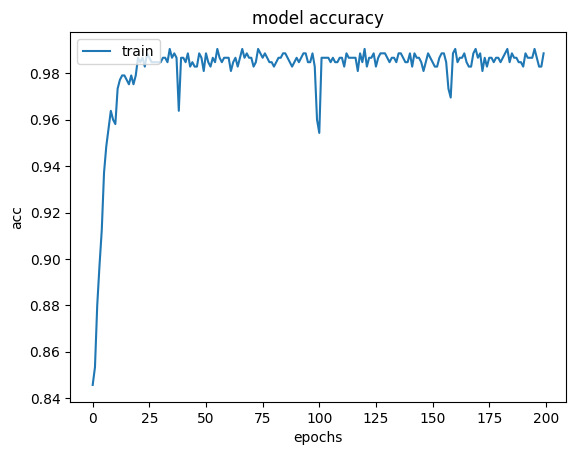

In [76]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

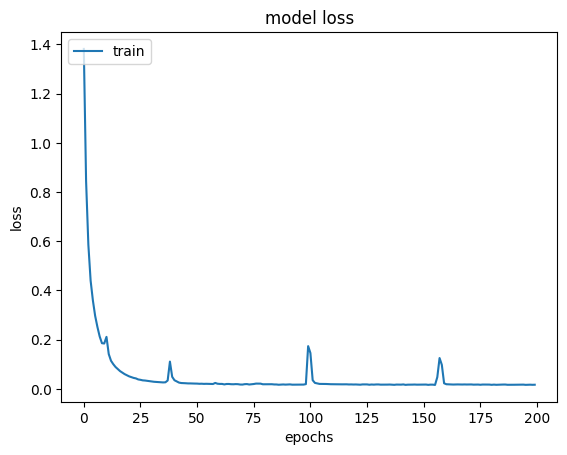

In [77]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Dự đoán ==> Chatbot

In [78]:
classes = pickle.load(open(f"{origin_path}/model/classes.pkl", "rb"))

In [79]:
import random
def response(tag):
    for i in intents['intents']:
        if i['tag'] == tag:
            return random.choice(i['responses'])

In [82]:
message = ['Ai tạo chatbot']
message = convert_to_no_accents(message[0])

seq = tokenizer.texts_to_sequences([message])

padded = pad_sequences(seq, maxlen=44, dtype='int32', value=0)

pred = model.predict(padded)

# labels = range(0, 113, 1)
print(pred)
print(response(classes[np.argmax(pred)]))

1/1 [==============================] - 0s 429ms/step
[[1.01683646e-12 1.27947674e-13 6.94193591e-10 7.83635323e-10
  1.43323131e-08 2.34721062e-11 7.09206971e-10 1.58984947e-09
  3.16915294e-09 5.93454452e-11 7.67199915e-10 2.02531394e-11
  7.63716672e-13 1.60366409e-09 3.93629435e-10 2.10068807e-09
  6.67832456e-10 7.27786165e-10 1.35477239e-06 5.49279289e-09
  2.56723198e-09 2.10163262e-10 1.12019425e-08 3.46093452e-06
  1.32755292e-06 5.90568046e-12 2.07049863e-10 3.19372305e-07
  2.14194938e-12 3.00069102e-11 2.90262022e-07 1.29764233e-12
  3.30391131e-10 6.24541521e-12 4.36455703e-05 1.82155055e-10
  1.64972072e-12 7.87908672e-09 1.37808254e-09 3.21867172e-10
  9.41165368e-08 1.56339297e-09 3.25723365e-10 2.43530729e-09
  9.99906421e-01 2.88111424e-09 2.14397888e-10 1.64835762e-06
  6.03295547e-08 1.27449438e-08 1.03503057e-12 1.38995787e-07
  3.50378607e-13 1.23400928e-10 2.86645837e-12 3.48516271e-10
  5.06595388e-09 4.59036767e-11 1.58270907e-09 1.52493007e-09
  4.10685402e-10 